### ▶️ Wir laden ein paar Python-Bibliotheken

In [2]:
import pandas as pd
import datetime
from IPython.display import display, HTML

### ▶️ Einlesen der vorbereiteten Daten vom Google-Drive

#### ⚠️Dieser Vorgang kann bis zu einer Minute dauern!⚠️
---

- Der Datensatz enthält alle Klimadaten von 20-01-2014 bis 20-01-2024 also der letzten zehn Jahre
- Er enthält "Mittlere (Tages)-Temperatur", "Sonnenscheindauer" und "(Mittlere)-Windgeschwindigkeit"
- Die .csv-Datei beinhaltet über 3 Millionen Datenpunkte und ist etwa 200 MegaByte gross

In [5]:
# Importiere die .csv-Datei mit den gesamten Klimadaten
df = pd.read_csv('https://drive.usercontent.google.com/download?id=11DYEiMTRVhMySsH5r3cDfCWBU2mqlNqO&export=download&authuser=0&confirm=t&uuid=1aa8951f-3209-4a18-986c-229dfc0f29e2&at=APZUnTVUwg__SVFWwQUEz9ft2zsy:1705864211167', index_col=False)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3861377 entries, 0 to 3861376
Data columns (total 4 columns):
 #   Column       Dtype  
---  ------       -----  
 0   Zeitstempel  object 
 1   Wert         float64
 2   Kategorie    object 
 3   Station      object 
dtypes: float64(1), object(3)
memory usage: 117.8+ MB


### ▶️ Zunächst müssen wir wieder ein paar Datentypen konvertieren

In [6]:
# Konvertiere "Zeitstempel" nach dateTime
df['Zeitstempel'] = pd.to_datetime(df.Zeitstempel)

# Konvertiere "Station" nach String
df['Station'] = df['Station'].astype("string")

# Konvertiere "Produkt_Titel" nach String
df['Kategorie'] = df['Kategorie'].astype("string")


### ▶️ Suchen von zehn möglichen Wohnorten die unsere drei Kriterien erfüllen

#### Erstes Teilkriterium ist die gewünschte Temperatur

☑️ Die mittlere Tagestemperatur soll in den Sommermonaten von 01. Juni bis 31. August die 25°C nicht überschritten haben in den letzten drei Jahren

In [7]:
# Wir filtern den gesamten Datensatz nach den Kriterien "Mittlere Tagestemperatur kleiner 25°C" in allen Jahren seit 2021
df_last_three_years = df.loc[((df['Kategorie'] == "Mittlere Temperatur") 
                      & (df['Zeitstempel'].dt.strftime('%Y') >= '2021'))]

######################################

# Danach limitieren wir die Daten auf den meteorologischen Sommer von 01. Juni bis 31. August in jedem Jahr
df_summer = df_last_three_years.loc[((df_last_three_years['Zeitstempel'].dt.strftime('%m') >= '06') 
            & (df_last_three_years['Zeitstempel'].dt.strftime('%m') < '09') & (df['Wert'] <= 25.0))]

df_summer = df_summer.sort_values(by=(['Station', 'Zeitstempel']), ascending=True).reset_index(drop=True)
#print(df_summer.head())

######################################

# Jeder Name einer Station darf nur einmal vorkommen
df_places = df_summer[~df_summer.duplicated(subset=['Station'])].copy()

# Wir erhalten ein Data-Frame nur mit den Stationen welche die Kriterien erfüllen
df_places = df_places.loc[:, ['Station']].sort_values(by=('Station'), ascending=True).reset_index(drop=True)

# Auskommentieren für eine Liste aller Orte
#for i in range(len(df_places)):
#    print("Ort" + str([i+1]) + ":" + df_places['Station'][i])

######################################

# Aus den Datensätzen der letzten drei Jahre wollen wir nur die Stationen welche die Kriterien erfüllen
df_criteria_1 = pd.merge(df_last_three_years, df_places, how="inner", on=['Station'])
df_criteria_1 = df_criteria_1.sort_values(by=(['Station', 'Zeitstempel']), ascending=True).reset_index(drop=True)

df_criteria_1.head()

,Zeitstempel,Wert,Kategorie,Station
0,2021-01-01,1.6,Mittlere Temperatur,Aachen-Orsbach
1,2021-01-02,0.9,Mittlere Temperatur,Aachen-Orsbach
2,2021-01-03,1.2,Mittlere Temperatur,Aachen-Orsbach
3,2021-01-04,0.5,Mittlere Temperatur,Aachen-Orsbach
4,2021-01-05,0.7,Mittlere Temperatur,Aachen-Orsbach


### ▶️ Suchen von zehn möglichen Wohnorten die unsere drei Kriterien erfüllen

#### Zweites Teilkriterium ist die gewünschte Sonnenscheindauer

☑️ Die Sonnenscheindauer soll an mindestens 200 Tagen 10 Stunden oder mehr betragen haben in den letzten drei Jahren

In [8]:
# Wir filtern den gesamten Datensatz nach den Kriterien "Sonnenscheindauer" in allen Jahren seit 2021
df_sun_last_three_years = df.loc[((df['Kategorie'] == "Sonnenscheindauer") 
                          & (df['Zeitstempel'].dt.strftime('%Y') >= '2021'))]

#df_sun_last_three_years.head()

######################################

# Die Sonne muss mindestens 10 Stunden geschienen haben
df_four_hours = df_sun_last_three_years.query('Wert >= 10.0')

# Wir zählen alle Tage an denen dies der Fall war und gruppieren nach Station
df_four_hours = df_four_hours.groupby('Station')[['Wert']].agg(['count']).reset_index()

######################################

# Auflösen der Mulit-Index Spalte in eine
df_four_hours.columns = ["_".join(c) for c in df_four_hours.columns]

# Dann umbennen in etwas sinnvolles
df_four_hours = df_four_hours.rename(columns={'Station_':'Station', 'Wert_count':'Anzahl'})

######################################

# An mindestens 200 Tagen wollen wir mindestens 10 Stunden Sonnenschein
df_twohundred_times = df_four_hours.query('Anzahl >= 200')
df_twohundred_times = df_twohundred_times.sort_values(by=('Anzahl'), ascending=False).reset_index(drop=True)

#print(df_twohundred_times.head())

######################################

# Wir erhalten ein Data-Frame nur mit den Stationen welche die Kriterien erfüllen
df_sun_places = df_twohundred_times.loc[:, ['Station']]
df_sun_places = df_sun_places.sort_values(by=('Station'), ascending=True).reset_index(drop=True)

# Auskommentieren für eine Liste aller Orte
#for i in range(len(df_sun_places)):
 #   print("Ort" + str([i+1]) + ":" + df_sun_places['Station'][i])

######################################

# Aus den Datensätzen der letzten drei Jahre wollen wir nur die Stationen welche die Kriterien erfüllen
df_criteria_2 = pd.merge(df_sun_last_three_years, df_sun_places, how="inner", on=['Station'])
df_criteria_2 = df_criteria_2.sort_values(by=(['Station', 'Zeitstempel']), ascending=True).reset_index(drop=True)

df_criteria_2.head()

,Zeitstempel,Wert,Kategorie,Station
0,2021-01-01,0.0,Sonnenscheindauer,"Altheim, Kreis Biberach"
1,2021-01-02,0.0,Sonnenscheindauer,"Altheim, Kreis Biberach"
2,2021-01-03,0.0,Sonnenscheindauer,"Altheim, Kreis Biberach"
3,2021-01-04,0.0,Sonnenscheindauer,"Altheim, Kreis Biberach"
4,2021-01-05,0.0,Sonnenscheindauer,"Altheim, Kreis Biberach"


### ▶️ Suchen von zehn möglichen Wohnorten die unsere drei Kriterien erfüllen

#### Drittes Teilkriterium ist die gewünschte Windgeschwindigkeit

☑️ Die mittlere Windgeschwindigkeit soll an mindestens 500 Tagen unter 2 m/s betragen haben in den letzten drei Jahren


In [9]:
# Wir filtern den gesamten Datensatz nach den Kriterien "Windgeschwindigkeit" in allen Jahren seit 2021
df_wind_last_three_years = df.loc[((df['Kategorie'] == "Windgeschwindigkeit") 
                           & (df['Zeitstempel'].dt.strftime('%Y') >= '2021'))]

#df_wind_last_three_years.head()

######################################

# Die Windgeschwindkeit muss unter 2 m/s gelegen haben
df_wind_speed = df_wind_last_three_years.query('Wert <= 2.0')

# Wir zählen alle Tage an denen dies der Fall war und gruppieren nach Station
df_wind_speed = df_wind_speed.groupby('Station')[['Wert']].agg(['count']).reset_index()

######################################

# Auflösen der Mulit-Index Spalte in eine
df_wind_speed.columns = ["_".join(c) for c in df_wind_speed.columns]

# Dann umbennen in etwas sinnvolles
df_wind_speed = df_wind_speed.rename(columns={'Station_':'Station', 'Wert_count':'Anzahl'})

######################################

# An mindestens 500 Tagen wollen wir weniger Wind als 2 m/s
df_fivehundred_winds = df_wind_speed.query('Anzahl >= 500')
df_fivehundred_winds = df_fivehundred_winds.sort_values(by=('Anzahl'), ascending=False).reset_index(drop=True)

#print(df_twohundred_winds.head())

######################################

# Wir erhalten ein Data-Frame nur mit den Stationen welche die Kriterien erfüllen
df_wind_places = df_fivehundred_winds.loc[:, ['Station']]
df_wind_places = df_wind_places.sort_values(by=('Station'), ascending=True).reset_index(drop=True)

# Auskommentieren für eine Liste aller Orte
#for i in range(len(df_wind_places)):
 #   print("Ort" + str([i+1]) + ":" + df_wind_places['Station'][i])

######################################

# Aus den Datensätzen der letzten drei Jahre wollen wir nur die Stationen welche die Kriterien erfüllen
df_criteria_3 = pd.merge(df_wind_last_three_years, df_wind_places, how="inner", 
                on=['Station']).sort_values(by=(['Station', 'Zeitstempel']), ascending=True).reset_index(drop=True)

df_criteria_3.head()

,Zeitstempel,Wert,Kategorie,Station
0,2021-01-01,1.1,Windgeschwindigkeit,Bamberg
1,2021-01-02,2.1,Windgeschwindigkeit,Bamberg
2,2021-01-03,1.5,Windgeschwindigkeit,Bamberg
3,2021-01-04,1.3,Windgeschwindigkeit,Bamberg
4,2021-01-05,2.6,Windgeschwindigkeit,Bamberg


In [10]:
# Berechnungen für "min", "max", "mean", "var" and "std" für jedes Kriterium, sortiert nach der Varianz
# Legende :
# "min"  --> minmial Temperatur während der letzten 3 Jahre in allen Stationen von Kriterium 1..3
# "max"  --> maximal Temperatur während der letzten 3 Jahre in allen Stationen von Kriterium 1..3
# "mean" --> median  Temperatur während der letzten 3 Jahre in allen Stationen von Kriterium 1..3
# "var"  --> varianz bzw. Variabilität während der letzten 3 Jahre in allen Stationen von Kriterium 1..3
# "std"  --> standard Abweichung während der letzten 3 Jahre in allen Stationen von Kriterium 1..3

# Wir analysieren Kriterium 1 also die mittleren Tagestemperaturen
df_stats_1 = df_criteria_1.groupby(["Station"])[["Wert"]].agg(['min', 'max', 'mean', 'var', 'std'])
df_stats_1 = df_stats_1.sort_values(by=('Wert','var'),ascending=True).reset_index()

########################################

# Wir analysieren Kriterium 2 also die Sonnenscheindauer
df_stats_2 = df_criteria_2.groupby(["Station"])[["Wert"]].agg(['min', 'max', 'mean', 'var', 'std'])
df_stats_2 = df_stats_2.sort_values(by=('Wert','var'),ascending=True).reset_index()

########################################

# Wir analysieren Kriterium 3 also die Windgeschwindigkeit
df_stats_3 = df_criteria_3.groupby(["Station"])[["Wert"]].agg(['min', 'max', 'mean', 'var', 'std'])
df_stats_3 = df_stats_3.sort_values(by=('Wert','var'),ascending=True).dropna().reset_index()

########################################

# Multi-Index auflösen und Spalten sinnvoll benennen
df_stats_1.columns = ["_".join(c) for c in df_stats_1.columns]
df_stats_1 = df_stats_1.rename(columns={'Wert_min':'Temperatur [min]', 'Wert_max':'Temperatur [max]', 'Wert_mean':'Temperatur [mean]'})
df_stats_1 = df_stats_1.rename(columns={'Station_': 'Station', 'Wert_var':'Temperatur [var]', 'Wert_std':'Temperatur [std]'})

########################################

# Multi-Index auflösen und Spalten sinnvoll benennen
df_stats_2.columns = ["_".join(c) for c in df_stats_2.columns]
df_stats_2 = df_stats_2.rename(columns={'Wert_min':'Sonne [min]', 'Wert_max':'Sonne [max]', 'Wert_mean':'Sonne [mean]'})
df_stats_2 = df_stats_2.rename(columns={'Station_': 'Station', 'Wert_var':'Sonne [var]', 'Wert_std':'Sonne [std]'})

########################################

# Multi-Index auflösen und Spalten sinnvoll benennen
df_stats_3.columns = ["_".join(c) for c in df_stats_3.columns]
df_stats_3 = df_stats_3.rename(columns={'Wert_min':'Wind [min]', 'Wert_max':'Wind [max]', 'Wert_mean':'Wind [mean]'})
df_stats_3 = df_stats_3.rename(columns={'Station_': 'Station', 'Wert_var':'Wind [var]', 'Wert_std':'Wind [std]'})

########################################

df_stats_result = pd.merge(df_stats_1, df_stats_2, on="Station")
df_stats_result = pd.merge(df_stats_result, df_stats_3, on="Station")

########################################

def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')

########################################

# Die ersten zehn Orte die alle Kriterien erfüllen nach der geringsten Varianz
df_stats_result = df_stats_result[0:10]
df_stats_result.head(12).style.bar(subset=('Temperatur [var]'), color='blue').bar(subset=('Sonne [var]'), color='#7715ea').bar(subset=('Wind [var]'), color='#074bf8')

,Station,Temperatur [min],Temperatur [max],Temperatur [mean],Temperatur [var],Temperatur [std],Sonne [min],Sonne [max],Sonne [mean],Sonne [var],Sonne [std],Wind [min],Wind [max],Wind [mean],Wind [var],Wind [std]
0,Neuhütten/Spessart,-10.000000,26.000000,9.444937,51.889952,7.203468,0.000000,14.983000,4.868774,21.350316,4.620640,0.600000,8.200000,2.487944,1.793615,1.339259
1,Stuttgart-Echterdingen,-9.000000,27.500000,10.004339,52.023620,7.212740,0.000000,15.667000,5.817633,22.986436,4.794417,0.600000,10.400000,2.490027,1.618237,1.272099
2,Kaisersbach-Cronhütte,-10.400000,26.000000,9.282601,53.604419,7.321504,0.000000,14.683000,4.958942,21.100666,4.593546,0.300000,6.600000,1.755526,0.808731,0.899295
3,Bamberg,-10.600000,26.300000,10.045740,54.029109,7.350450,0.000000,15.217000,4.687102,20.618769,4.540789,0.500000,5.900000,1.872087,0.672466,0.820040
4,Offenbach-Wetterpark,-8.400000,29.000000,11.373543,54.075933,7.353634,0.000000,15.433000,5.202909,21.661631,4.654206,0.600000,7.200000,2.198023,1.115931,1.056377
5,Konstanz,-6.800000,26.500000,10.742870,54.080171,7.353922,0.000000,15.267000,5.611643,22.377980,4.730537,0.800000,9.000000,2.389058,1.607744,1.267968
6,"Weingarten, Kr. Ravensburg",-7.900000,25.800000,10.157309,55.412126,7.443932,0.000000,14.650000,5.736882,22.145392,4.705889,0.700000,7.900000,2.217106,1.182312,1.087342
7,Freiburg,-6.300000,28.300000,12.045471,56.142913,7.492857,0.000000,14.683000,5.232693,20.913880,4.573170,0.700000,9.000000,2.625946,2.391295,1.546381
8,Kempten,-10.900000,24.900000,8.941435,56.699969,7.529938,0.000000,14.000000,5.173017,19.485238,4.414209,0.600000,6.500000,1.938126,0.506824,0.711916
9,Wielenbach (Demollstr.),-10.800000,25.800000,9.420987,56.996310,7.549590,0.000000,13.733000,5.316048,18.927342,4.350557,0.500000,9.100000,1.836106,1.287418,1.134644


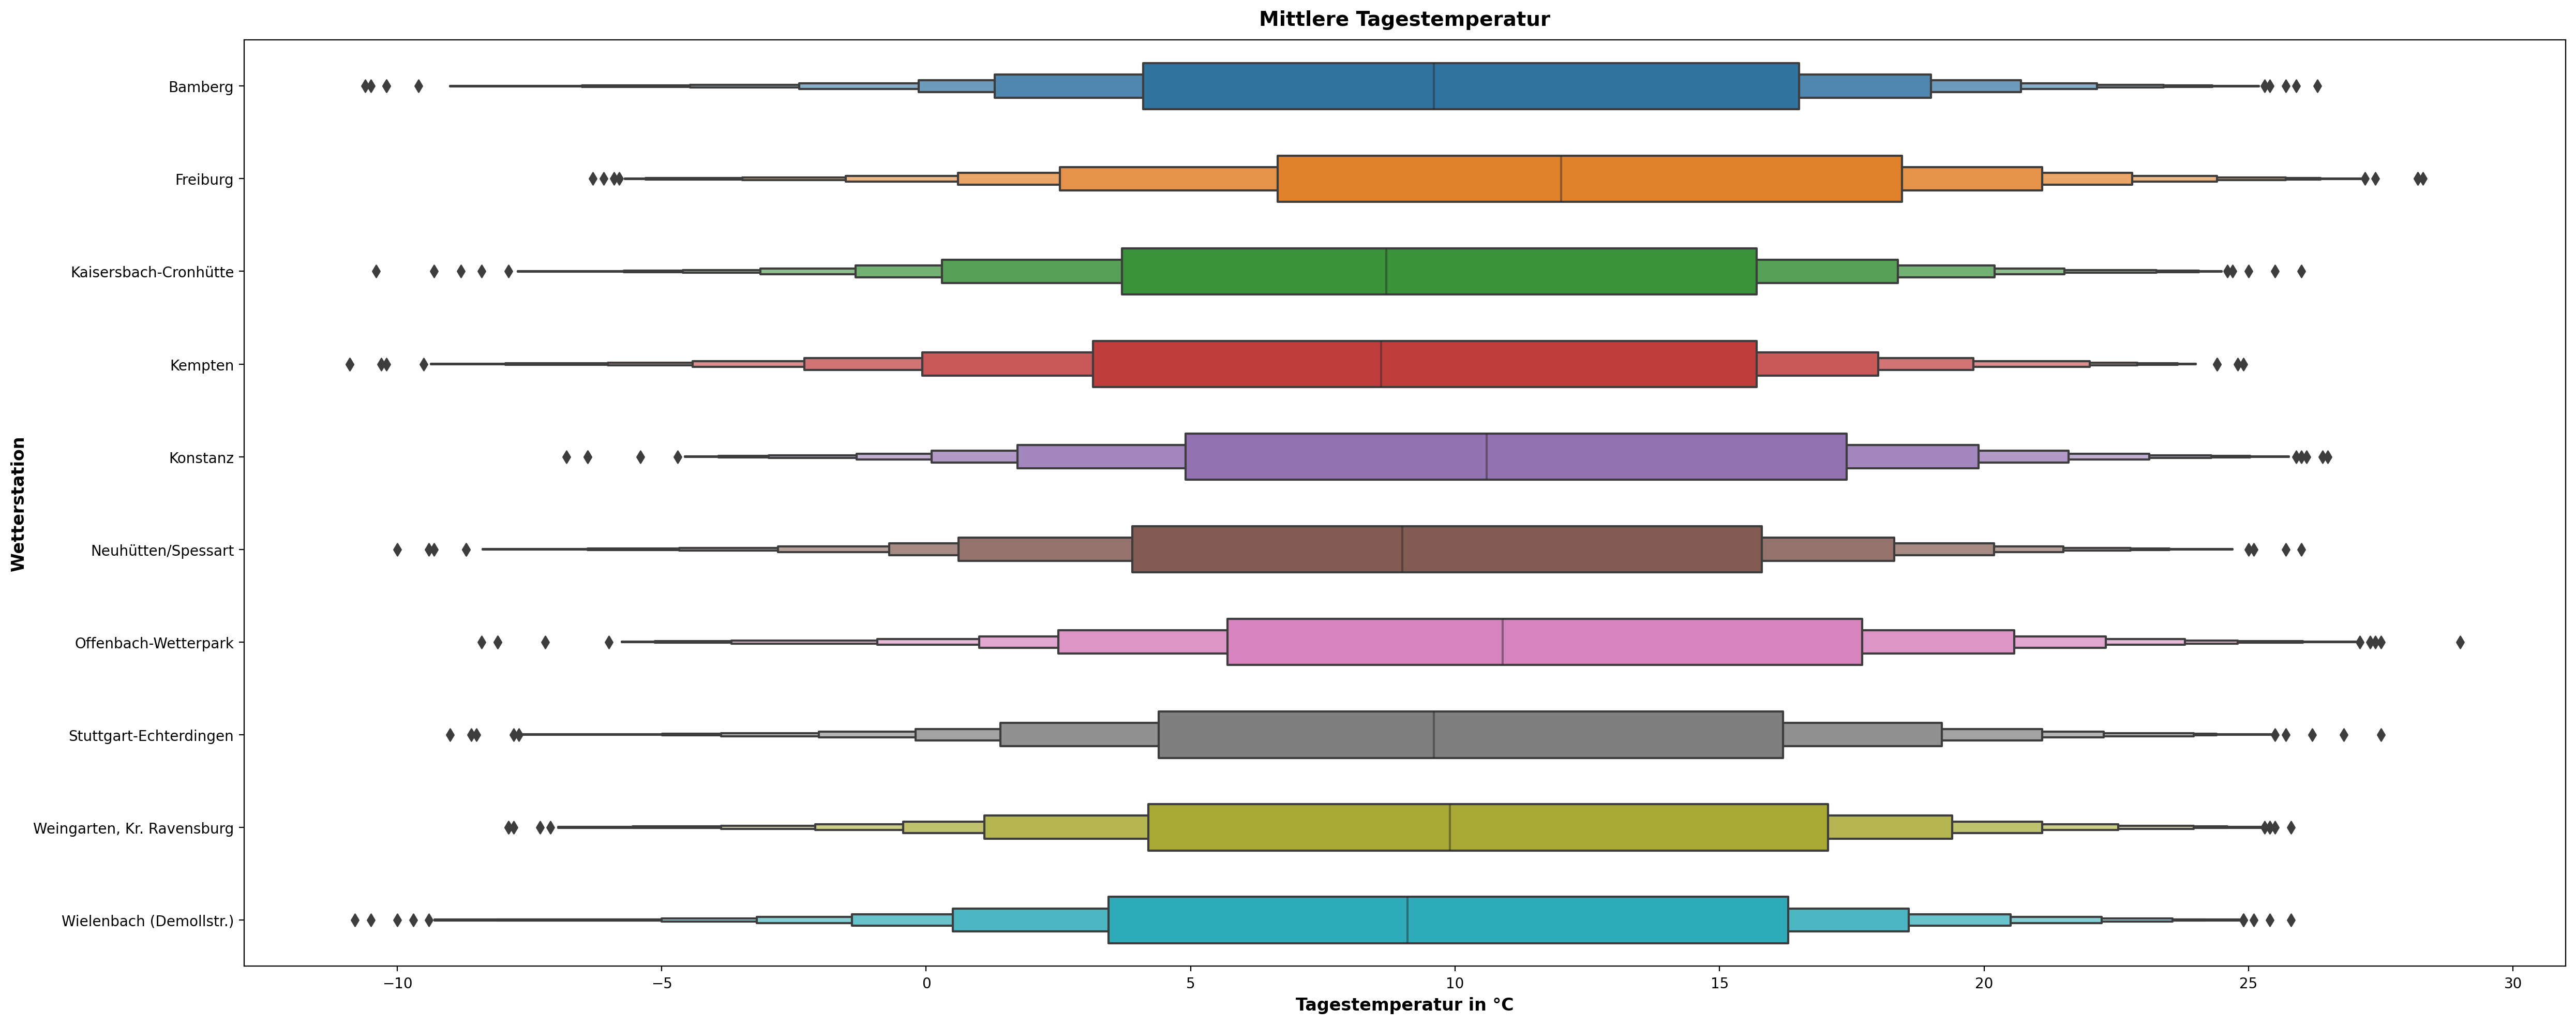

In [12]:
import seaborn as sns
from matplotlib import pyplot as plt

# Wir erhalten ein Data-Frame nur mit den Stationen welche die Kriterien erfüllen
df_result_places = df_stats_result.loc[:, ['Station']]
#print(df_result_places.head())

######################################

# Aus den Datensätzen der letzten drei Jahre wollen wir nur die Stationen welche die Kriterien erfüllen
# Datensätze für die mittlere Tagestemperatur
df_boxplot_1 = pd.merge(df_last_three_years, df_result_places, how="inner", on=['Station'])
df_boxplot_1 = df_boxplot_1.sort_values(by=(['Station', 'Zeitstempel']), ascending=True).reset_index(drop=True)

# Aus den Datensätzen der letzten drei Jahre wollen wir nur die Stationen welche die Kriterien erfüllen
# Datensätze für die Sonnenscheindauer
df_boxplot_2 = pd.merge(df_sun_last_three_years, df_result_places, how="inner", on=['Station'])
df_boxplot_2 = df_boxplot_2.sort_values(by=(['Station', 'Zeitstempel']), ascending=True).reset_index(drop=True)

# Aus den Datensätzen der letzten drei Jahre wollen wir nur die Stationen welche die Kriterien erfüllen
# Datensätze für die Windgeschwindigkeit
df_boxplot_3 = pd.merge(df_wind_last_three_years, df_result_places, how="inner", on=['Station'])
df_boxplot_3 = df_boxplot_3.sort_values(by=(['Station', 'Zeitstempel']), ascending=True).reset_index(drop=True)

#df_boxplot_2.head()


plt.figure(figsize=(25,10))

plot = sns.boxenplot(data=df_boxplot_1, x=df_boxplot_1[('Wert')], y=df_boxplot_1[('Station')], width=.5)
plot.set(title="Mittlere Tagestemperatur", xlabel="Tagestemperatur in °C", ylabel="Wetterstation");


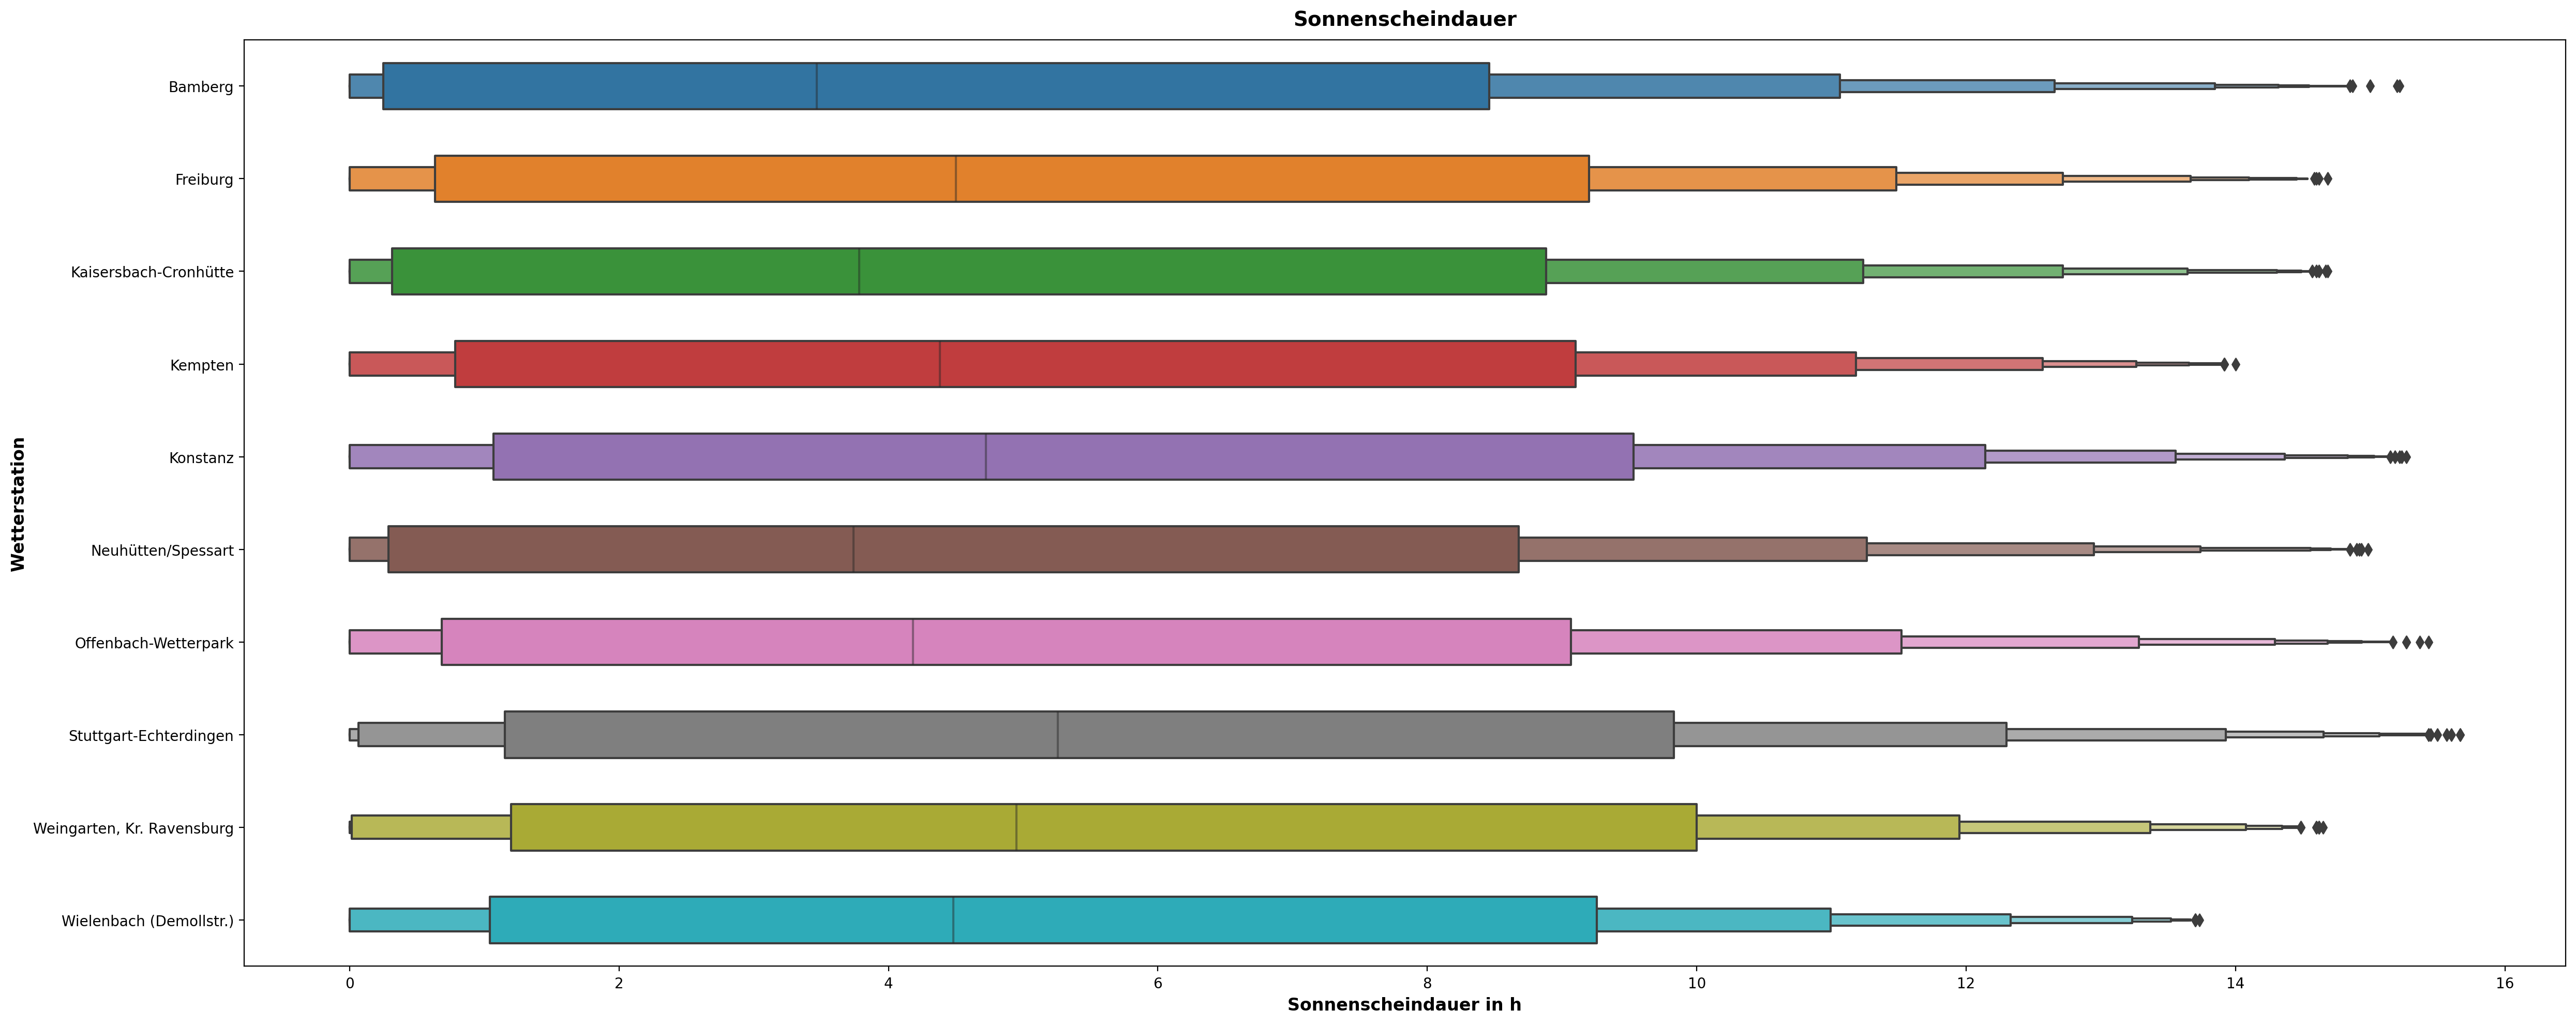

In [13]:
plt.figure(figsize=(25,10))

plot = sns.boxenplot(data=df_boxplot_2, x=df_boxplot_2[('Wert')], y=df_boxplot_2[('Station')], width=.5)
plot.set(title="Sonnenscheindauer", xlabel="Sonnenscheindauer in h", ylabel="Wetterstation");

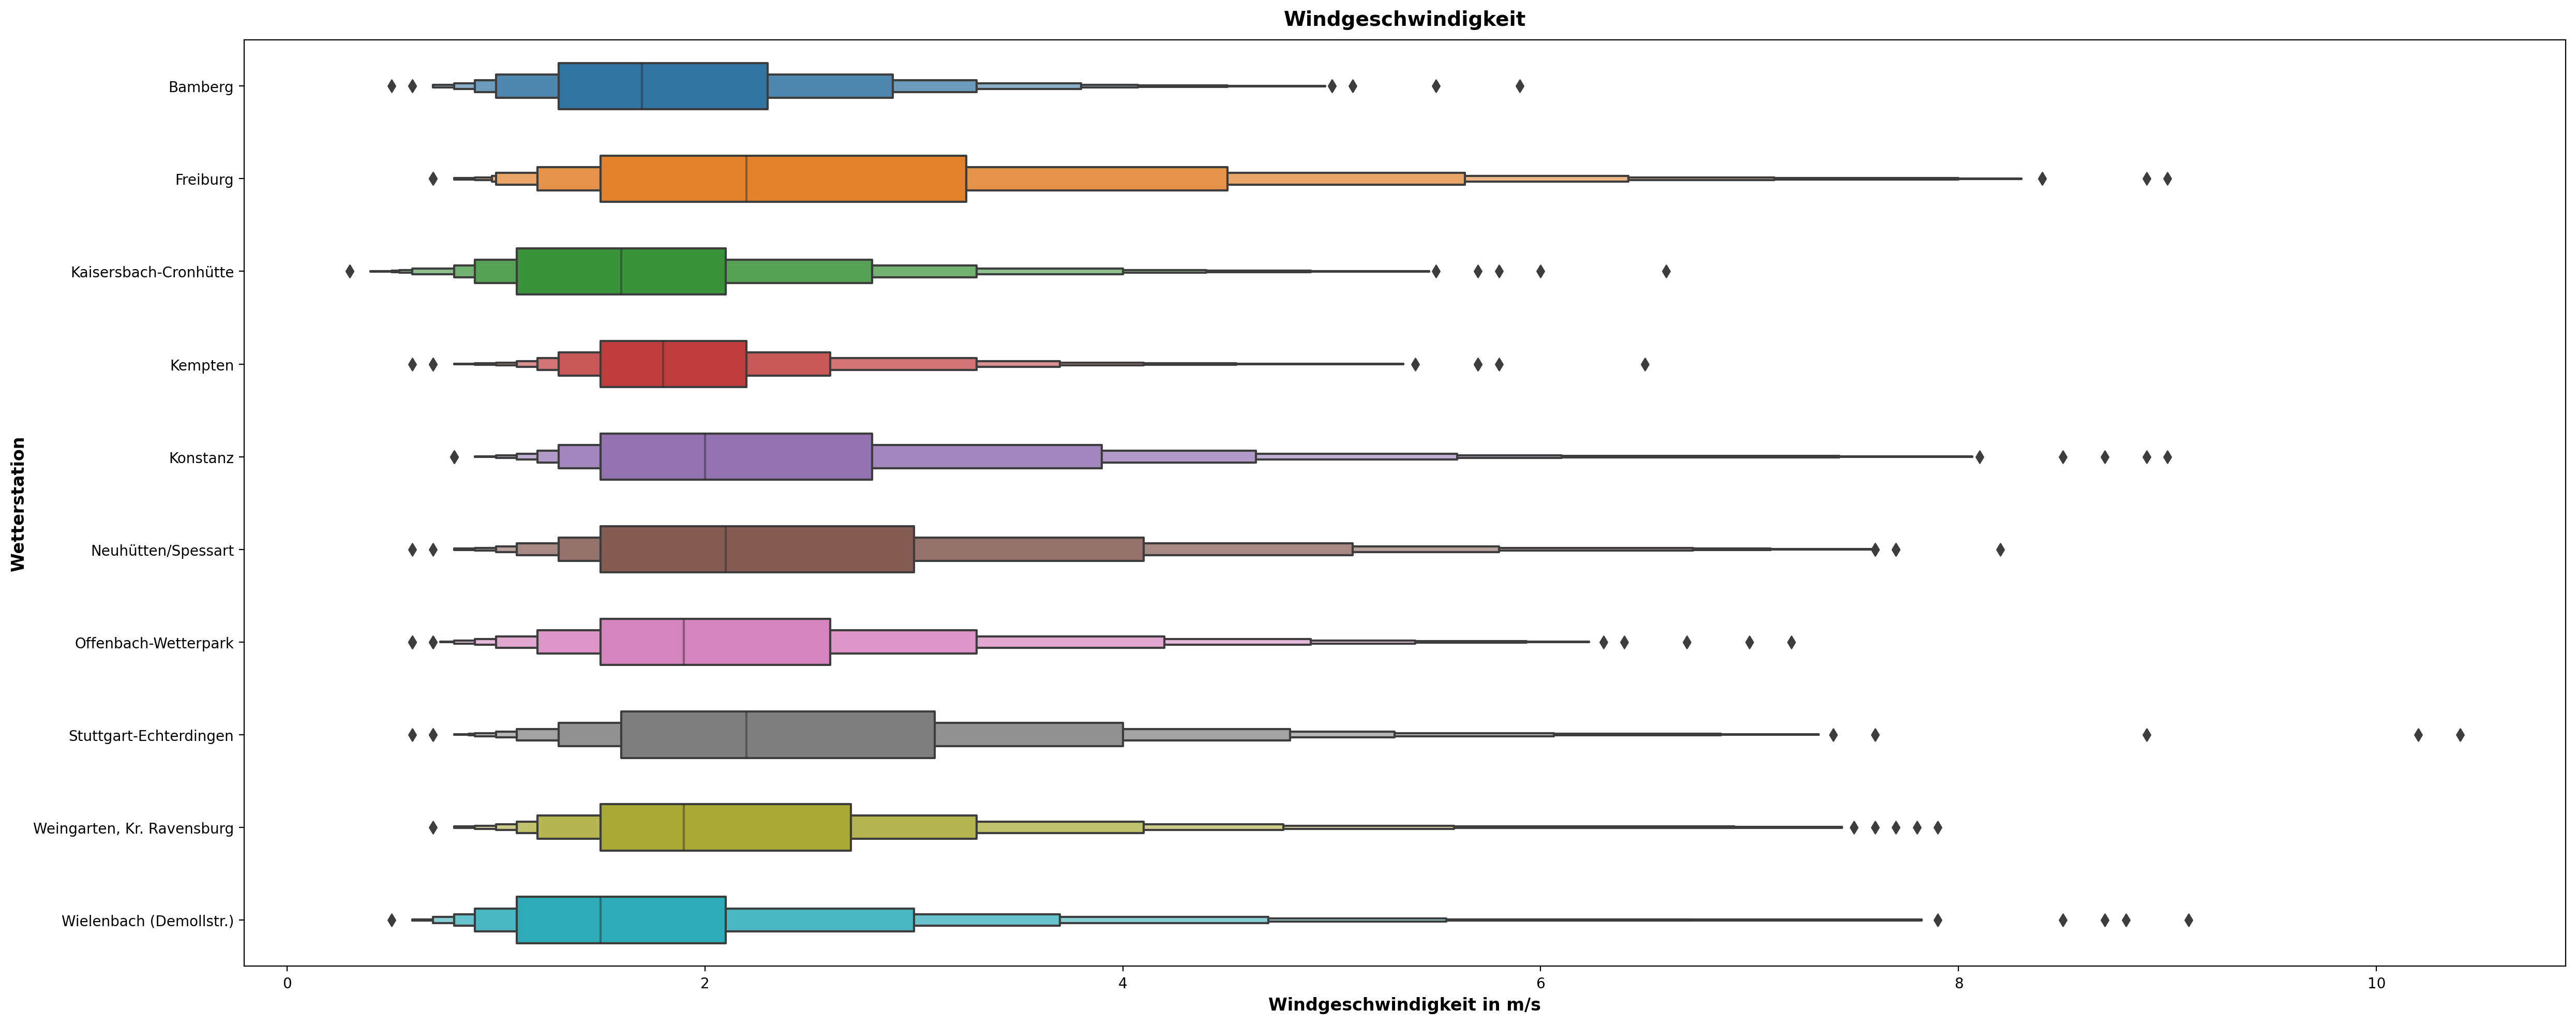

In [14]:
plt.figure(figsize=(25,10))

#plot = sns.relplot(data=df_stats_result, x=df_stats_result[('Temperatur [var]')], y=df_stats_result['Sonne [var]'], hue="Station", palette="ch:r=-.5,l=.75")
plot = sns.boxenplot(data=df_boxplot_3, x=df_boxplot_3[('Wert')], y=df_boxplot_3[('Station')], width=.5)
plot.set(title="Windgeschwindigkeit", xlabel="Windgeschwindigkeit in m/s", ylabel="Wetterstation");


Mittleres Abweichungsquadrat: 7.66


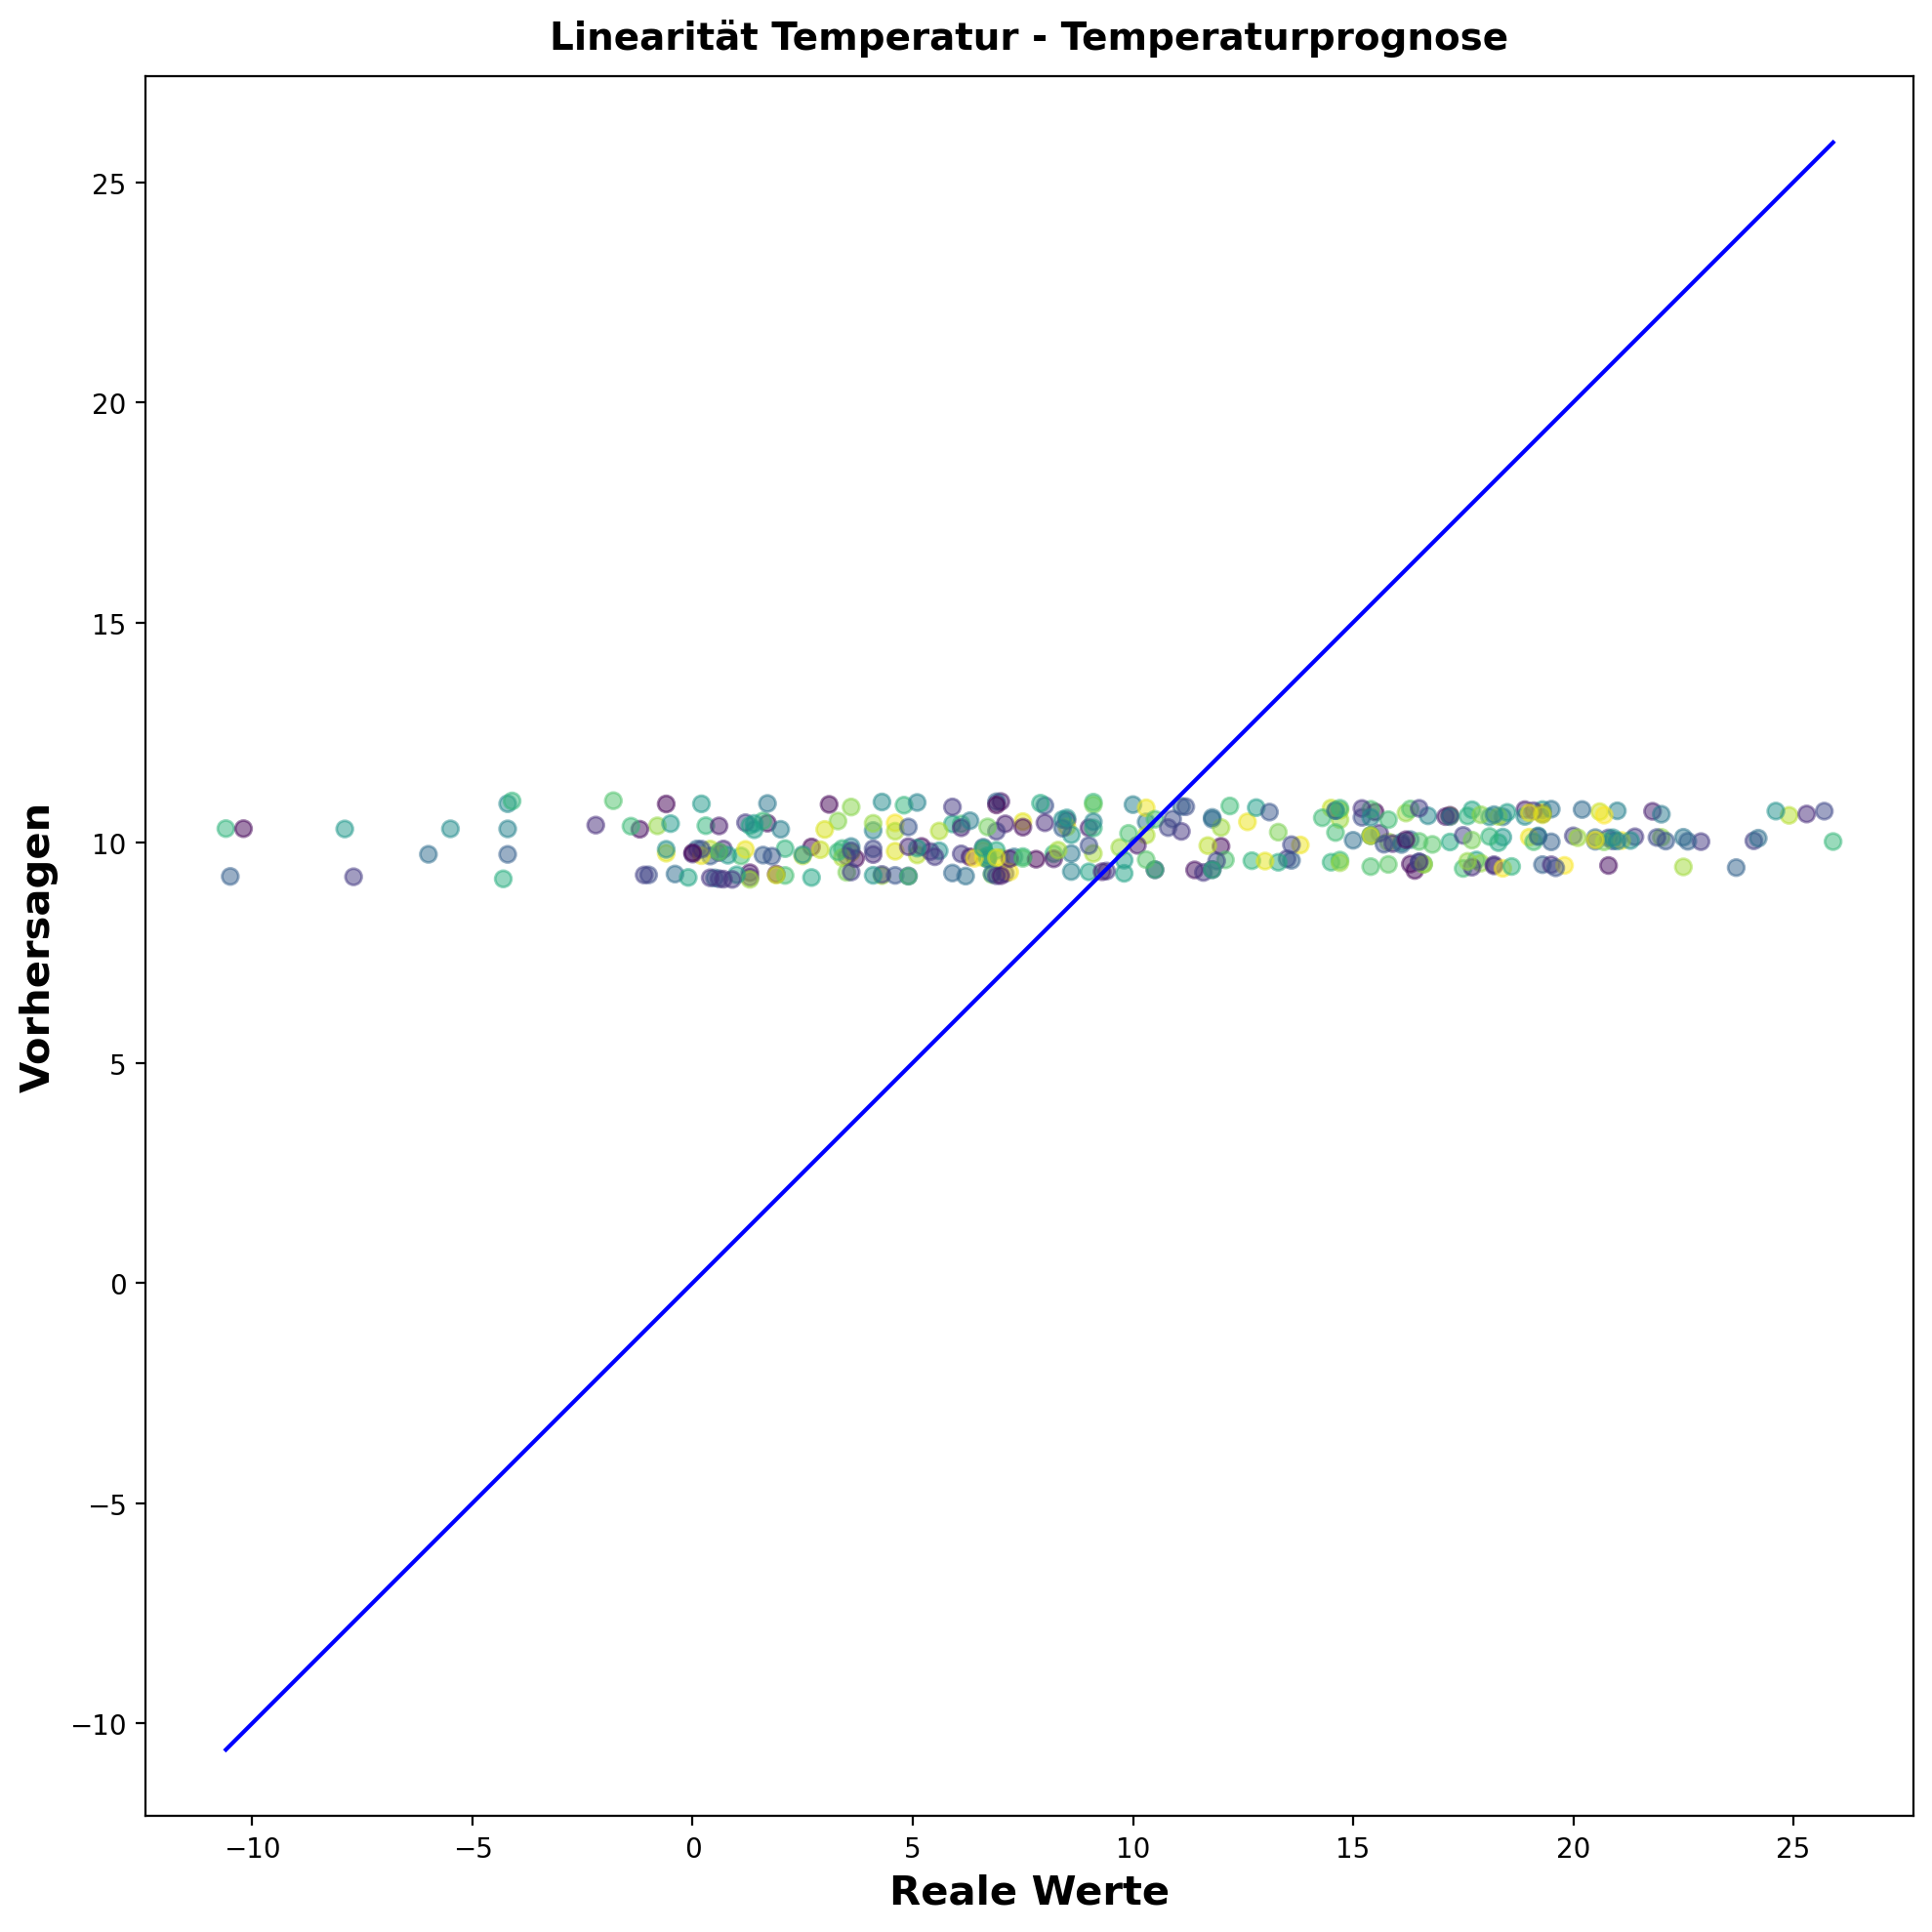

In [85]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

# Zum splitten des Datensatzes in Test und Train
from sklearn.model_selection import train_test_split

# Metric zum Evaluieren
from sklearn.metrics import mean_squared_error

# Statsmodels für Linear Regression
import statsmodels.api as sm

# Ignoriere Warnungen
import warnings
warnings.filterwarnings("ignore")

# Nehmen die Daten von unserem idealen Ort Bamberg
df_linear = df_boxplot_1.loc[((df_boxplot_1['Station'] == "Bamberg"))]
df_linear = df_linear.drop(['Station', 'Kategorie', 'Zeitstempel'], axis=1)

df_linear = df_linear.reset_index(drop=True)

df_linear

X = df_linear.index
y = df_linear.loc[:, 'Wert']

# Erstelle Test und Traing-Daten
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                  test_size = .3, # 30% of data for testing
                                                  shuffle = True, # Shuffling values
                                                  random_state = 42)

# Konstante hinzufügen
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fitting model
model = sm.OLS(y_train, X_train).fit()

#print(model.summary(alpha = 0.05))

# Starte Vorhersage
y_pred = model.predict(X_test) 

# Ermittle Fehler
rmse = mean_squared_error(y_test, y_pred,squared = False)
print(f'\nMittleres Abweichungsquadrat: {rmse:.2f}')

N = 335
colors = np.random.rand(N)

plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred, c=colors, alpha=0.5)
plt.title("Linearität Temperatur - Temperaturprognose")

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Reale Werte', fontsize=15)
plt.ylabel('Vorhersagen', fontsize=15)
plt.axis('equal')
plt.show()
